# Product Bundles Recommender System on E-commerce Data by Association Rules
## Aiden Ahmet Erdogan

The developed system aims to elevate the online shopping experience through the integration of a recommendation engine, utilizing a public dataset sourced from the UCI Machine Learning Repository. This dataset encompasses a year's worth of transactional data from an online store.

The primary objective is to optimize product bundle recommendations by leveraging association rules derived from the dataset. The goal is to maximize the likelihood of purchase by suggesting relevant product bundles for each item. In instances where recommendations are lacking or insufficient for a particular product, we address the issue by completing or recommending from the most frequently suggested options to mitigate the cold start problem.

This system is designed to proactively address customer preferences within the online store environment by providing personalized product recommendations based on individual selections.

The advantages of such a system are extensive, benefiting both customers and the company:

- **For Customers:** Personalized recommendations streamline the product discovery process, enhancing user satisfaction and overall shopping experience. By facilitating the search for future purchases, customers are more inclined to return, fostering increased loyalty.

- **For the Company:** Implementation of a recommendation engine cultivates customer loyalty, thereby reducing churn rates and associated costs linked to acquiring new customers. Additionally, through cross-selling complementary products, the company can diversify revenue streams. In instances where recommendations are insufficient, strategies are employed to address the cold start problem by completing or recommending from the most commonly suggested options.

# Set up environment: Import some libraries & data transformation

In [1]:
from mlxtend.frequent_patterns import fpgrowth, association_rules # Recommendation Algorithm - FP-Growth

import numpy as np # linear algebra
import pandas as pd # data manipulations
import seaborn as sns # used for plot interactive graph
import matplotlib.pyplot as plt # this is used for the plots

%matplotlib inline
import time


# Loading Dataset

In [2]:
data = pd.read_csv('data.csv', encoding='latin1') # or encoding='ISO-8859-1' # import data from a csv file

# Data Analysis

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Analysis Summary:

The dataset comprises 541,909 records distributed across 8 columns. Each column is briefly described as follows:

1. InvoiceNo: Object data type indicating transaction invoice numbers, potentially representing multiple items per transaction.
2. StockCode: Object data type representing unique product codes.
3. Description: Object data type containing product descriptions, with 540,455 non-null entries.
4. Quantity: Integer column denoting the quantity of products bought per transaction.
5. InvoiceDate: Datetime column recording transaction timestamps.
6. UnitPrice: Float column indicating the unit price of each product.
7. CustomerID: Float column containing customer IDs, with 406,829 non-null entries.
8. Country: Object column specifying the transaction location country.

Initial observations reveal missing values in the Description and CustomerID columns. The InvoiceDate column is appropriately formatted for time series analysis. Additionally, the presence of repeated CustomerID entries suggests multiple transactions by the same customer.

Subsequent steps entail comprehensive data cleaning to handle missing values and potential errors, as well as feature engineering to aid in achieving project objectives.

In [5]:
# Summerize statustics

# Summary statistics for numerical variables
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [6]:
# Summary statistics for categorical variables
data.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


Findings Summary:

InvoiceDate:
- Records transaction date and time.

Quantity:
- Average transaction quantity: 9.55.
- Wide range: -80995 to 80995, negative values denote returns.
- High standard deviation suggests data spread and outliers.

UnitPrice:
- Average unit price: $4.61.
- Range: -11062.06 to $38970, indicating data errors.
- Outliers suggested by large range.

CustomerID:
- 406,829 non-null entries, indicating missing values.
- IDs range from 12346 to 18287, aiding customer identification.

InvoiceNo:
- 25,900 unique invoices, representing separate transactions.
- Most frequent: 573585, occurring 1114 times.

StockCode:
- 4,070 unique stock codes.
- Most frequent: 85123A, appearing 2313 times.

Description:
- 4,223 unique product descriptions.
- Most frequent: "WHITE HANGING HEART T-LIGHT HOLDER," 2369 occurrences.
- Missing values need treatment.

Country:
- Transactions from 38 countries.
- Predominantly from the UK (91.4%).

# Cleaning

Convert InvoiceDate to datetime type


In [7]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

Initially, I will determine the percentage of missing values present in each column, followed by selecting the most effective strategy to address them:

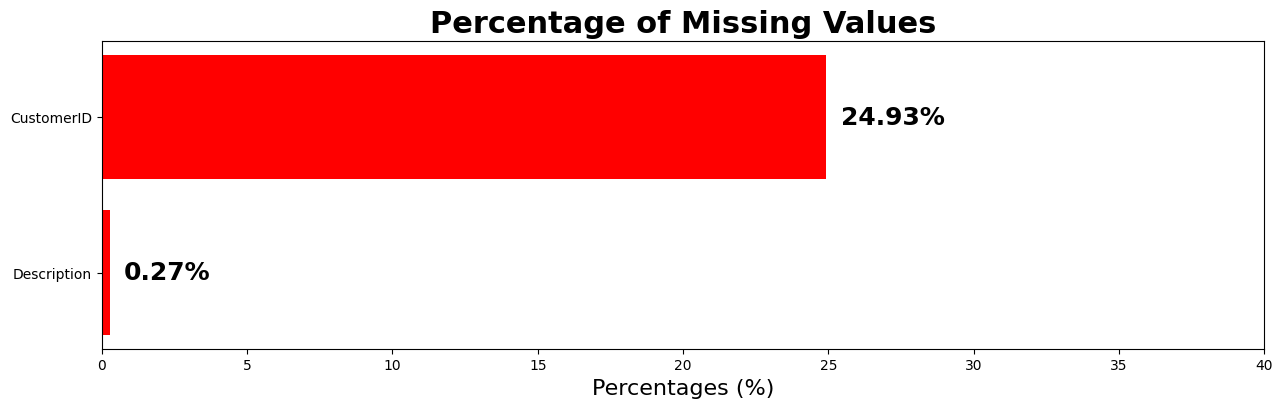

In [8]:
# Find and calculate the percentage of missing values
missing_data = data.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / data.shape[0]) * 100

# Prepare values by sorting
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the bar-chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='red')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')
# Set X-axis limit
ax.set_xlim([0, 40])
# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

Handling Missing Values Approach:

CustomerID (24.93% missing values):

- The CustomerID column has a substantial portion of missing data, approximately a quarter. Since this column is fundamental for constructing a recommendation system based on customer behavior, imputing such a large percentage of missing values could introduce significant bias or noise.

- Additionally, accurate customer identifiers are crucial for effective product recommendations. Therefore, the most appropriate strategy appears to be removing rows with missing CustomerIDs to ensure the integrity of the analysis.

Description (0.27% missing values):

- The Description column has a minor proportion of missing values. However, inconsistencies in data suggest that not all StockCodes correspond to consistent Descriptions, indicating data quality issues.

- Due to these inconsistencies, imputing missing descriptions based solely on StockCodes may not yield reliable results. Given the low percentage of missing values and the potential for error propagation, removing rows with missing Descriptions seems prudent to maintain data reliability.

By eliminating rows with missing values in the CustomerID and Description columns, the objective is to establish a cleaner and more dependable dataset, crucial for accurate and effective recommendation system outcomes.

In [9]:
# Rows where either 'CustomerID' or 'Description' is null
data.loc[data[['CustomerID', 'Description']].isnull().any(axis=1)].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [10]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
data = data.dropna(subset=['CustomerID', 'Description'])

# Verifying the removal of missing values
data.isnull().sum().sum()

0

In [11]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = data[data.duplicated(keep=False)]

# Arranging the data based on specific columns to ensure that duplicate rows are grouped together.
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom


Duplicate Handling Strategy:

Within the scope of this project, the existence of entirely identical rows, even with identical transaction timestamps, indicates potential data recording errors rather than legitimate repeated transactions. Retaining these duplicate rows could introduce unwanted noise and inaccuracies into the recommendation system.

Hence, the plan is to eliminate these entirely identical duplicate rows from the dataset. This action will contribute to obtaining a more refined dataset, facilitating the development of more precise product recommendations based on customers' distinct purchasing patterns. Furthermore, it will enhance the accuracy of the recommendation system by correctly identifying the most frequently purchased products.

In [12]:
# Displaying the number of duplicate rows
print(f"The dataset has {data.duplicated().sum()} duplicate rows that should be eliminated.")


# Removing duplicate rows
data.drop_duplicates(inplace=True)

The dataset has 5225 duplicate rows that should be eliminated.


In [13]:
# Calculating the number of rows in the dataframe:

num_rows = len(data)
print(f"The dataframe contains {num_rows} rows.")


The dataframe contains 401604 rows.


Handling Cancelled Transactions:

In order to enhance our comprehension of customer behavior and preferences, it's essential to consider transactions that were cancelled. Our approach involves initially identifying these transactions by filtering rows where the InvoiceNo starts with "C". Subsequently, we'll conduct an analysis of these rows to discern any common characteristics or patterns they exhibit.

In [14]:
invoice_to_del = [el for el in data['InvoiceNo'].unique() if el[0] == 'C'] #find invoices to cancelled
data=data[data['InvoiceNo'].map(lambda x: x not in invoice_to_del)] # delete these products

Key Observations from Cancelled Transactions Data:

- All quantities in cancelled transactions are negative, indicating their status as cancelled orders.
- The UnitPrice column displays significant variability, suggesting that cancelled transactions encompass a wide range of product values.

Handling Cancelled Transactions Strategy:

Given the project's objective of developing a recommendation system based on customer behavior, understanding cancellation patterns is crucial. Hence, the strategy is to preserve cancelled transactions in the dataset, clearly marking them for future analysis. This approach offers the following advantages:

- Enables the recommendation system to potentially avoid suggesting products with a high cancellation probability, thus enhancing recommendation quality.

In [15]:
# # Finding the percentage of cancelled transactions
# cancelled_percentage = (cancelled_transactions.shape[0] / data.shape[0]) * 100

# # Printing the percentage of cancelled transactions
# print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

Rectifying StockCode Anomalies:

- To start, we'll determine the count of unique stock codes and then plot the top 10 most frequent stock codes along with their percentage frequency.

In [16]:
# Finding the count of unique stock codes
unique_stock_codes = data['StockCode'].nunique()

# Printing the count of unique stock codes
print(f"The count of unique stock codes in the dataset is: {unique_stock_codes}")

The count of unique stock codes in the dataset is: 3665


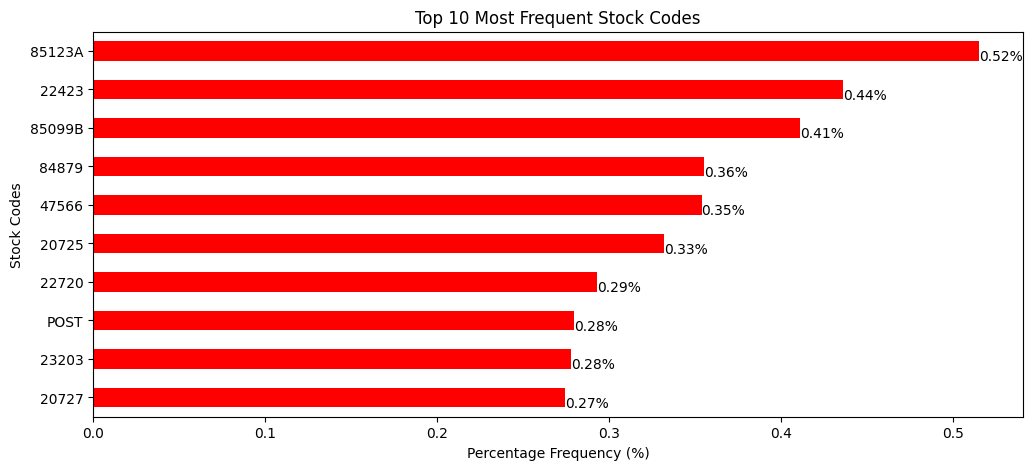

In [17]:
# Finding the top 10 most frequent stock codes

top_10_stock_codes = data['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes

plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='red')

# Adding the percentage frequency on the bars

for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

Inferences on Stock Codes:

- **Product Variety:** The dataset encompasses 3684 unique stock codes, indicating a wide array of products available in the online retail store. This diversity holds potential for identifying distinct preferences among customers, contributing to the creation of tailored recommendation systems catering to different product types.

- **Popular Items:** Examining the top 10 most frequent stock codes provides insights into the products or categories that enjoy significant popularity among customers, guiding strategic decisions regarding inventory management and marketing efforts.

- **Stock Code Anomalies:** Anomalies in stock codes, such as the presence of entries like 'POST', deviate from the typical format observed in most codes, which consist of 5 or 6 characters. These anomalies may represent non-product transactions, such as postage fees or services, rather than actual products. To uphold the project's focus on creating a recommendation system based on product transactions, it's imperative to investigate and potentially address these anomalies to maintain data integrity.

To further investigate these anomalies, let's analyze the frequency of numeric characters in the stock codes. This analysis can shed light on the nature of these unusual entries:

In [18]:
# Extracting unique stock codes
unique_stock_codes = data['StockCode'].unique()

# Counting numeric characters in each unique stock code
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Displaying the frequency distribution of numeric character counts
print("Frequency distribution of numeric character counts in unique stock codes:")
print("-" * 70)
print(numeric_char_counts_in_unique_codes)


Frequency distribution of numeric character counts in unique stock codes:
----------------------------------------------------------------------
5    3659
0       5
1       1
Name: count, dtype: int64


Inference:

The analysis reveals the following:

- The majority of unique stock codes (3676 out of 3684) conform to the standard format of containing exactly 5 numeric characters, suggesting consistency in representing product codes within the dataset.

- However, there are anomalies: 7 stock codes contain no numeric characters, and 1 stock code contains only 1 numeric character. These deviations from the standard format require further investigation to determine their nature and ascertain whether they represent valid product transactions.

Next, let's identify the stock codes that contain 0 or 1 numeric characters to gain deeper insights into these anomalies:

In [19]:
# Finding stock codes with 0 or 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing anomalous stock codes
print("Anomalous stock codes:")
print("-" * 22)
for code in anomalous_stock_codes:
    print(code)


Anomalous stock codes:
----------------------
POST
C2
M
BANK CHARGES
PADS
DOT


Let's calculate the percentage of records with these anomalous stock codes:

In [20]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (data['StockCode'].isin(anomalous_stock_codes).sum() / len(data)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.39%


Inference:

- The analysis reveals that only a small fraction of records, approximately 0.48%, have anomalous stock codes, which differ from the standard format observed in the majority of the dataset. Moreover, these anomalous codes represent just a fraction of all unique stock codes (only 8 out of 3684).

- These anomalous codes appear to denote non-product transactions, such as "BANK CHARGES" and "POST" (likely postage fees). As they do not pertain to actual products and constitute a negligible portion of the dataset, including them in the analysis could introduce noise and distort the recommendation system.

Strategy:

- Given the project's objective of developing a product recommendation system, it's advisable to exclude records with anomalous stock codes from the dataset. By doing so, the focus remains solely on genuine product transactions, ensuring a more accurate and meaningful analysis.

Therefore, the strategy involves filtering out and removing rows with anomalous stock codes from the dataset before proceeding with further analysis and model development:

In [21]:
# Removing rows with anomalous stock codes from the dataset
data = data[~data['StockCode'].isin(anomalous_stock_codes)]

# Getting the number of rows in the dataframe
data.shape[0]

391183

Cleaning Description Column

First, I will calculate the occurrence count of each unique description in the dataset. Then, I will plot the top 30 descriptions. This visualization will give a clear view of the highest occurring descriptions in the dataset:
Inferences on Descriptions:

To clean the Description column, we'll first calculate the occurrence count of each unique description in the dataset. Then, we'll plot the top 30 descriptions to visualize the most frequently occurring ones:

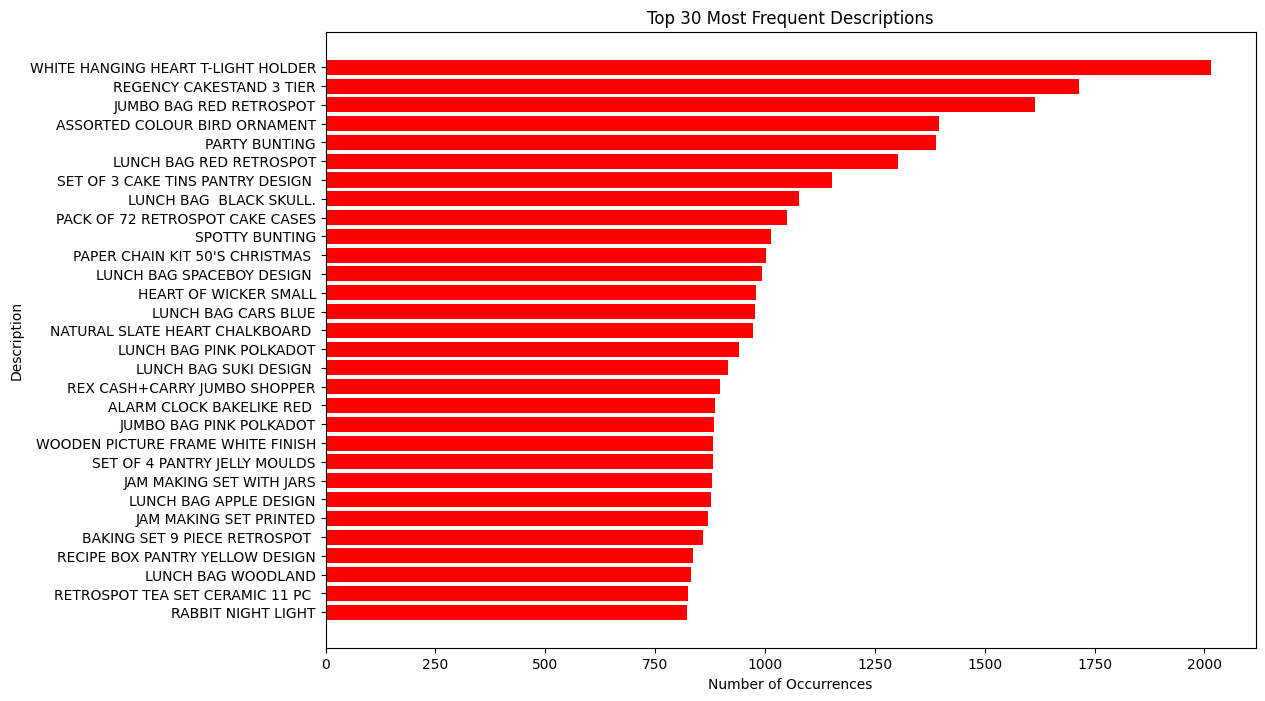

In [22]:
# Calculate the occurrence of each unique description and sort them
description_counts = data['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='red')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()


Inferences on Descriptions:

- The predominant descriptions are typically related to household items, particularly those associated with kitchenware, lunch bags, and decorative items. This suggests that these categories might be popular among customers or heavily stocked by the retailer.

- Notably, all descriptions are in uppercase, indicating a standardized format for entering product descriptions in the database. However, given the inconsistencies and anomalies encountered in the dataset, it would be prudent to verify whether descriptions are entered in lowercase or a mix of case styles. This validation could help identify potential data entry errors or inconsistencies that may impact data quality and subsequent analysis.

To find unique descriptions containing lowercase characters, we iterate through the unique descriptions and filter out those that contain at least one lowercase character. Then, we print these unique descriptions:

In [23]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = data['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("Unique descriptions containing lowercase characters:")
print("-" * 60)
for desc in lowercase_descriptions:
    print(desc)


Unique descriptions containing lowercase characters:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
NUMBER TILE COTTAGE GARDEN No
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


Inference:

Upon examining descriptions containing lowercase characters, it's apparent that certain entries, such as "Next Day Carriage" and "High Resolution Image," do not pertain to product descriptions. These entries likely represent other types of information or service details unrelated to actual products.

Strategy:

1. **Remove Service-related Entries:** 
    - We'll begin by removing rows where descriptions contain service-related information like "Next Day Carriage" and "High Resolution Image." These entries are irrelevant to the products and would not contribute to the recommendation system we aim to build.

2. **Standardize Case:** 
    - For the remaining descriptions with mixed case, we'll standardize the text to uppercase. This step ensures uniformity across the dataset and reduces the likelihood of having duplicate entries with different case styles.

Implementing this strategy will enhance the dataset's quality, making it more suitable for the analysis and modeling phases of our project.

In [24]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = data[data['Description'].isin(service_related_descriptions)].shape[0] / data.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
data = data[~data['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
data['Description'] = data['Description'].str.upper()


The percentage of records with service-related descriptions in the dataset is: 0.02%


In [25]:
# Getting the number of rows in the dataframe
num_rows = data.shape[0]
print(f"The number of rows in the dataframe is: {num_rows}")


The number of rows in the dataframe is: 391101


Treating Zero Unit Prices

In this step, first I am going to take a look at the statistical description of the UnitPrice column:

In [26]:
# Descriptive statistics for the 'UnitPrice' column
unit_price_stats = data['UnitPrice'].describe()
print(unit_price_stats)


count    391101.000000
mean          2.871599
std           4.281346
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64


Inference:

The minimum unit price value being zero suggests that there are transactions where the unit price is zero, which could indicate either a free item or a data entry error. To gain a better understanding of these zero unit price transactions, further investigation is essential. A detailed analysis of the product descriptions associated with zero unit prices will be conducted to identify any patterns or anomalies. This analysis will help determine the nature of these transactions and whether they are legitimate or indicative of errors in data entry.

In [27]:
data[data['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000
std,2176.713608


Inferences on UnitPrice:

- There are relatively few transactions (33 in total) with a unit price of zero.
- These transactions exhibit a wide range of quantities involved, spanning from 1 to 12540, with a substantial standard deviation.

Strategy:

- Due to the small number of transactions with zero unit price and their potential to introduce noise in data analysis, the recommended strategy is to remove these transactions from the dataset. This approach ensures the maintenance of a cleaner and more consistent dataset, which is crucial for constructing an accurate and reliable recommendation system.

In [28]:
# Removing records with a unit price of zero to avoid potential data entry errors
data = data[data['UnitPrice'] > 0]

In [29]:
# Resetting the index of the cleaned dataset
data.reset_index(drop=True, inplace=True)

# Getting the number of rows in the dataframe
data.shape[0]

391068

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391068 entries, 0 to 391067
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    391068 non-null  object        
 1   StockCode    391068 non-null  object        
 2   Description  391068 non-null  object        
 3   Quantity     391068 non-null  int64         
 4   InvoiceDate  391068 non-null  datetime64[ns]
 5   UnitPrice    391068 non-null  float64       
 6   CustomerID   391068 non-null  float64       
 7   Country      391068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 23.9+ MB


# Association Rules modelling : Fp growth algorithm

Fp Growth is a Data Mining model based on **association rules**.

This model allows, from a transaction history, to determine the set of most frequent association rules in the dataset. To do so, it needs as input parameter the set of transactions composed of the product baskets the customers have already purchased. 

Step-1: Given a dataset of transactions, the first step of FP-growth is to calculate item frequencies and identify frequent items.

Step-2: The second step of FP-growth uses a suffix tree (FP-tree) structure to encode transactions without generating candidate sets explicitly, which are usually expensive to generate. After the second step, the frequent itemsets can be extracted from the FP-tree and the model returns a set of product association rules like the example below: 

            {Product A + Product B} --> {Product C} with 60% probability
            {Product B + Product C} --> {Product A + Product D} with 78% probability
            {Prodcut C} --> {Product B + Product D} with 67% probability
            etc.
            
To establish this table, the model needs to be provided with 2 hyperparameters :
* **minSupRatio** : minimum support for an itemset to be identified as frequent. For example, if an item appears 3 out of 5 transactions, it has a support of 3/5=0.6.
* **minConf** :minimum confidence for generating Association Rule. Confidence is an indication of how often an association rule has been found to be true. For example, if in the transactions itemset X appears 4 times, X and Y co-occur only 2 times, the confidence for the rule X => Y is then 2/4 = 0.5. The parameter will not affect the mining for frequent itemsets, but specify the minimum confidence for generating association rules from frequent itemsets.

Once the association rules have been calculated, all you have to do is apply them to the customers' product baskets. 

In [31]:
# Recommendation Algorithm - FP-Growth
# One-hot encode the data for Market Basket Analysis
basket = (data.groupby(['InvoiceNo', 'StockCode'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

print("Basket Shape: ", basket.shape)

basket.head()

Basket Shape:  (18399, 3657)


StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Convert quantity to binary values (0 or 1)
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_16890/283358427.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(encode_units)


In [33]:
a=time.time()
# Generate frequent item sets using FP-Growth
frequent_itemsets_fp = fpgrowth(basket_sets, min_support=0.005, use_colnames=True)

# Generate association rules
rules_fp = association_rules(frequent_itemsets_fp, metric="lift", min_threshold=0.5)
b=time.time()
print(b-a)
rules_fp.shape

/opt/anaconda3/envs/conrad_rpb/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


2.751400947570801


(16636, 10)

In [34]:
# antecedents is basket
# consequents is nex_product
# confidence is probablity

rules = rules_fp[['antecedents', 'consequents', 'confidence']]

associations=rules.sort_values(by='confidence',ascending=False)
print('Dimensions of the association table are : ', associations.shape)
associations.head(10)

Dimensions of the association table are :  (16636, 3)


,antecedents,consequents,confidence
8390,"(22916, 22921, 22919, 22917, 22920)",(22918),0.992481
8131,"(22917, 22919, 22916, 22921)",(22918),0.985915
8228,"(22917, 22918, 22921, 22920)",(22916),0.985612
8227,"(22917, 22916, 22921, 22920)",(22918),0.985612
8300,"(22917, 22919, 22921, 22920)",(22918),0.985294
8329,"(22919, 22916, 22921, 22920)",(22918),0.985294
8387,"(22916, 22918, 22921, 22919, 22920)",(22917),0.985075
8391,"(22918, 22921, 22919, 22917, 22920)",(22916),0.985075
15883,"(23170, 23172, 22697)",(23171),0.981308
15636,"(23170, 23174, 23172)",(23171),0.981132


In [35]:
# Rename columns in associations DataFrame
associations.rename(columns={'antecedents': 'basket', 'consequents': 'product_to_recommend', 'confidence': 'probability'}, inplace=True)

In [36]:
# # Convert frozenset to list
# associations['basket'] = associations['basket'].apply(list)
# associations['product_to_recommend'] = associations['product_to_recommend'].apply(list)

# associations

In [37]:
# Sort DataFrame by 'InvoiceDate' in descending order
df = data.sort_values(by='InvoiceDate', ascending=False)

# Get unit prices and descriptions
unit_prices = df.groupby('StockCode')['UnitPrice'].first()
product_descriptions = df.groupby('StockCode')['Description'].first()


In [38]:
def get_price(product_ids):
    return round(sum(unit_prices.get(product_id, 0) for product_id in product_ids), 2)

def get_description(product_ids):
    return ', '.join(product_descriptions.get(product_id, '') for product_id in product_ids)


In [39]:
# Apply functions to create new columns
associations["price"] = associations["product_to_recommend"].apply(get_price)
associations["description"] = associations["product_to_recommend"].apply(get_description)

associations

,basket,product_to_recommend,probability,price,description
8390,"(22916, 22921, 22919, 22917, 22920)",(22918),0.992481,0.65,HERB MARKER PARSLEY
8131,"(22917, 22919, 22916, 22921)",(22918),0.985915,0.65,HERB MARKER PARSLEY
8228,"(22917, 22918, 22921, 22920)",(22916),0.985612,0.65,HERB MARKER THYME
8227,"(22917, 22916, 22921, 22920)",(22918),0.985612,0.65,HERB MARKER PARSLEY
8300,"(22917, 22919, 22921, 22920)",(22918),0.985294,0.65,HERB MARKER PARSLEY
...,...,...,...,...,...
10562,(85123A),(84596B),0.046512,0.42,SMALL DOLLY MIX DESIGN ORANGE BOWL
7443,(85123A),(21790),0.046512,0.85,VINTAGE SNAP CARDS
12253,(85123A),(23207),0.046512,1.65,LUNCH BAG ALPHABET DESIGN
2001,(85123A),(22464),0.046512,0.79,HANGING METAL HEART LANTERN


In [40]:
# Define the product list for which you want recommendations
product_of_interest = '21756'

# Filter association rules for the product of interest
filtered_rules =  associations[associations['basket'] == frozenset({product_of_interest})]

# Sort the filtered rules based on lift (or any other relevant metric)
top_recommendations = filtered_rules.sort_values(by='probability', ascending=False).head(10)

# Display the top recommendations
print("Top 10 Recommendations for", product_of_interest)
top_recommendations


Top 10 Recommendations for 21756


,basket,product_to_recommend,probability,price,description
148,(21756),(21754),0.578512,6.25,HOME BUILDING BLOCK WORD
150,(21756),(21755),0.404959,6.25,LOVE BUILDING BLOCK WORD


In [41]:
# Define the product for which you want recommendations
product_of_interest = '22920'

# Filter association rules for the product of interest
filtered_rules =  associations[associations['basket'] == frozenset({product_of_interest})]

# Sort the filtered rules based on lift (or any other relevant metric)
top_recommendations = filtered_rules.sort_values(by='probability', ascending=False).head(10)

# Display the top recommendations
print("Top 10 Recommendations for", product_of_interest)
top_recommendations


Top 10 Recommendations for 22920


,basket,product_to_recommend,probability,price,description
7849,(22920),(22917),0.914894,0.65,HERB MARKER ROSEMARY
7863,(22920),(22918),0.904255,0.65,HERB MARKER PARSLEY
7901,(22920),(22916),0.898936,0.65,HERB MARKER THYME
7851,(22920),(22919),0.893617,0.65,HERB MARKER MINT
7915,(22920),"(22917, 22916)",0.861702,1.30,"HERB MARKER ROSEMARY, HERB MARKER THYME"
7875,(22920),"(22917, 22918)",0.845745,1.30,"HERB MARKER ROSEMARY, HERB MARKER PARSLEY"
7857,(22920),"(22917, 22919)",0.845745,1.30,"HERB MARKER ROSEMARY, HERB MARKER MINT"
7921,(22920),"(22916, 22918)",0.840426,1.30,"HERB MARKER THYME, HERB MARKER PARSLEY"
7881,(22920),"(22919, 22918)",0.829787,1.30,"HERB MARKER MINT, HERB MARKER PARSLEY"
7953,(22920),"(22919, 22916)",0.829787,1.30,"HERB MARKER MINT, HERB MARKER THYME"


# Results

#### Anticipation of customer needs :

In [42]:
print('On average, the recommendation system can predict in', associations['probability'].mean() * 100, '% of the cases the next product that the customer will buy.')


On average, the recommendation system can predict in 36.67114585471023 % of the cases the next product that the customer will buy.


#### Turnover generated :

In [43]:
print('With only 1 single product proposed, the recommendation system can generate a turnover in this case up to:', round(associations['price'].sum()), 'euros.')


With only 1 single product proposed, the recommendation system can generate a turnover in this case up to: 51735 euros.


Among a product catalog of more than 3000 items, a simple model based on association rules can predict in approximately **37%** of the cases the next product that the customer will buy, thereby generating significant additional revenue.

The advantage of this model lies in its high accuracy while being easy to implement and explain. Unlike some other artificial intelligence models that may appear as "black boxes" due to their complexity, the results of the FP-Growth model are understandable. In the association table, you will find all the rules specific to your business. For instance, if your customers frequently purchase product A and product B together, you will immediately see this association in your association table!

# Operationalize

In [44]:
# associations.to_csv("association_rules.csv")

# frequent_itemsets_fp.to_csv("frequent_itemsets_fp.csv")

# unit_prices.to_csv("unit_prices.csv")



In [45]:
rules_fp

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(22111),(84029E),0.035654,0.017447,0.005489,0.153963,8.824838,0.004867,1.161360,0.919466
1,(84029E),(22111),0.017447,0.035654,0.005489,0.314642,8.824838,0.004867,1.407068,0.902428
2,(84029E),(21485),0.017447,0.028969,0.005326,0.305296,10.538725,0.004821,1.397762,0.921183
3,(21485),(84029E),0.028969,0.017447,0.005326,0.183865,10.538725,0.004821,1.203910,0.932114
4,(22112),(84029E),0.038046,0.017447,0.005163,0.135714,7.778838,0.004500,1.136839,0.905912
...,...,...,...,...,...,...,...,...,...,...
16631,(23581),(23583),0.016414,0.016197,0.007283,0.443709,27.395284,0.007017,1.768504,0.979576
16632,(23581),(23344),0.016414,0.031850,0.005272,0.321192,10.084663,0.004749,1.426251,0.915873
16633,(23344),(23581),0.031850,0.016414,0.005272,0.165529,10.084663,0.004749,1.178694,0.930475
16634,(23203),(23581),0.058699,0.016414,0.005109,0.087037,5.302631,0.004145,1.077356,0.862014


In [46]:
frequent_itemsets_fp

,support,itemsets
0,0.107506,(85123A)
1,0.017447,(84029E)
2,0.017338,(84029G)
3,0.016142,(22752)
4,0.013588,(71053)
...,...,...
4537,0.005381,"(23583, 23209)"
4538,0.005055,"(23583, 20727)"
4539,0.007283,"(23583, 23581)"
4540,0.005272,"(23581, 23344)"


In [47]:
unit_prices

StockCode
10002     0.85
10080     0.39
10120     0.21
10123C    0.65
10124A    0.42
          ... 
90214U    0.29
90214V    0.29
90214W    0.29
90214Y    0.29
90214Z    0.29
Name: UnitPrice, Length: 3657, dtype: float64

In [48]:
# Function to get bundle for a product ID
def get_bundle(product_id, associations=associations,frequent_itemsets_fp=frequent_itemsets_fp, num_products=5):
    if product_id in associations["basket"].apply(list).explode().values:
        # Get association rules related to the provided product ID
        product_rules = associations[associations['basket'] == frozenset({product_id})]
        bundle_products = []
        bundle_price = 0
        
        if not product_rules.empty:
            # Sort by probability to get most relevant associations
            product_rules = product_rules.sort_values(by='probability', ascending=False)

            # Add products from antecedents and consequents of association rules
            for _, row in product_rules.iterrows():
                bundle_products = bundle_products + (list(row['product_to_recommend']))
                
                # Check if the desired number of products is reached
                if len(set(bundle_products)) >= num_products:
                    break
            
            bundle_products = list(set(bundle_products))
            # Get the total price for the bundle
            bundle_price = round(sum(unit_prices.get(product, 0) for product in bundle_products), 2)

        if len(bundle_products) < num_products or product_rules.empty:
            # If no association rules found for the product, pick from top frequent items
            frequent_itemsets = frequent_itemsets_fp.sort_values("support", ascending=False)
            frequent_items = list(frequent_itemsets["itemsets"].apply(lambda x: list(x)).explode())
            uniques_frequent_items = [x for x in frequent_items if x not in bundle_products]
            sample_size = (num_products-len(bundle_products))
            bundle_products = list(bundle_products)+ uniques_frequent_items[:sample_size]
            bundle_products = list(set(bundle_products))

            # Get the total price for the bundle
            bundle_price = round(sum(unit_prices.get(product, 0) for product in bundle_products), 2)
            
            return bundle_products, bundle_price
        else:
            return list(bundle_products), bundle_price

    else:
        return "Product ID not found in the dataset"


In [49]:
# Example usage:
product_id = '22920'  # Replace with the desired product ID
bundle_result = get_bundle(product_id)
if isinstance(bundle_result, tuple):
    bundle_products, bundle_price = bundle_result
    print("Bundle Products:", bundle_products)
    print("Bundle Price:", bundle_price)
else:
    print(bundle_result)

Bundle Products: ['22916', '22918', '22921', '22919', '22917']
Bundle Price: 3.25


In [50]:
# Example usage:
product_id = '23170'  # Replace with the desired product ID
bundle_result = get_bundle(product_id)
if isinstance(bundle_result, tuple):
    bundle_products, bundle_price = bundle_result
    print("Bundle Products:", bundle_products)
    print("Bundle Price:", bundle_price)
else:
    print(bundle_result)

Bundle Products: ['22423', '23171', '22699', '23172', '23173']
Bundle Price: 28.95
